In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from google.colab import files
uploaded = files.upload()


# Here I loaded the Dataset
df = pd.read_csv('DatasetAfricaMalaria.csv')

Saving DatasetAfricaMalaria.csv to DatasetAfricaMalaria (2).csv


In [38]:
from google.colab import files
import joblib

# Saved the model and scaler to files
joblib.dump(rf, 'malaria_model.pkl')       # Saves model
joblib.dump(scaler, 'scaler.pkl')             # Saves scaler

# File Download
files.download('malaria_model.pkl')
files.download('scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
# Basic Info
print(df.info())
print(df.describe())

# Checking for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 27 columns):
 #   Column                                                                                   Non-Null Count  Dtype  
---  ------                                                                                   --------------  -----  
 0   Country Name                                                                             594 non-null    object 
 1   Year                                                                                     594 non-null    int64  
 2   Country Code                                                                             594 non-null    object 
 3   Incidence of malaria (per 1,000 population at risk)                                      550 non-null    float64
 4   Malaria cases reported                                                                   550 non-null    float64
 5   Use of insecticide-treated bed nets (% of under-5 population)   

In [24]:
# Droped columns with too many missing values or irrelevant features
cols_to_drop = ['geometry', 'Country Code', 'Country Name', 'Malaria cases reported']
df_clean = df.drop(cols_to_drop, axis=1)

# Filled missing values with median (for numerical) or mode (for categorical)
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
    else:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)

/tmp/ipython-input-24-535216124.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].median(), inplace=True)


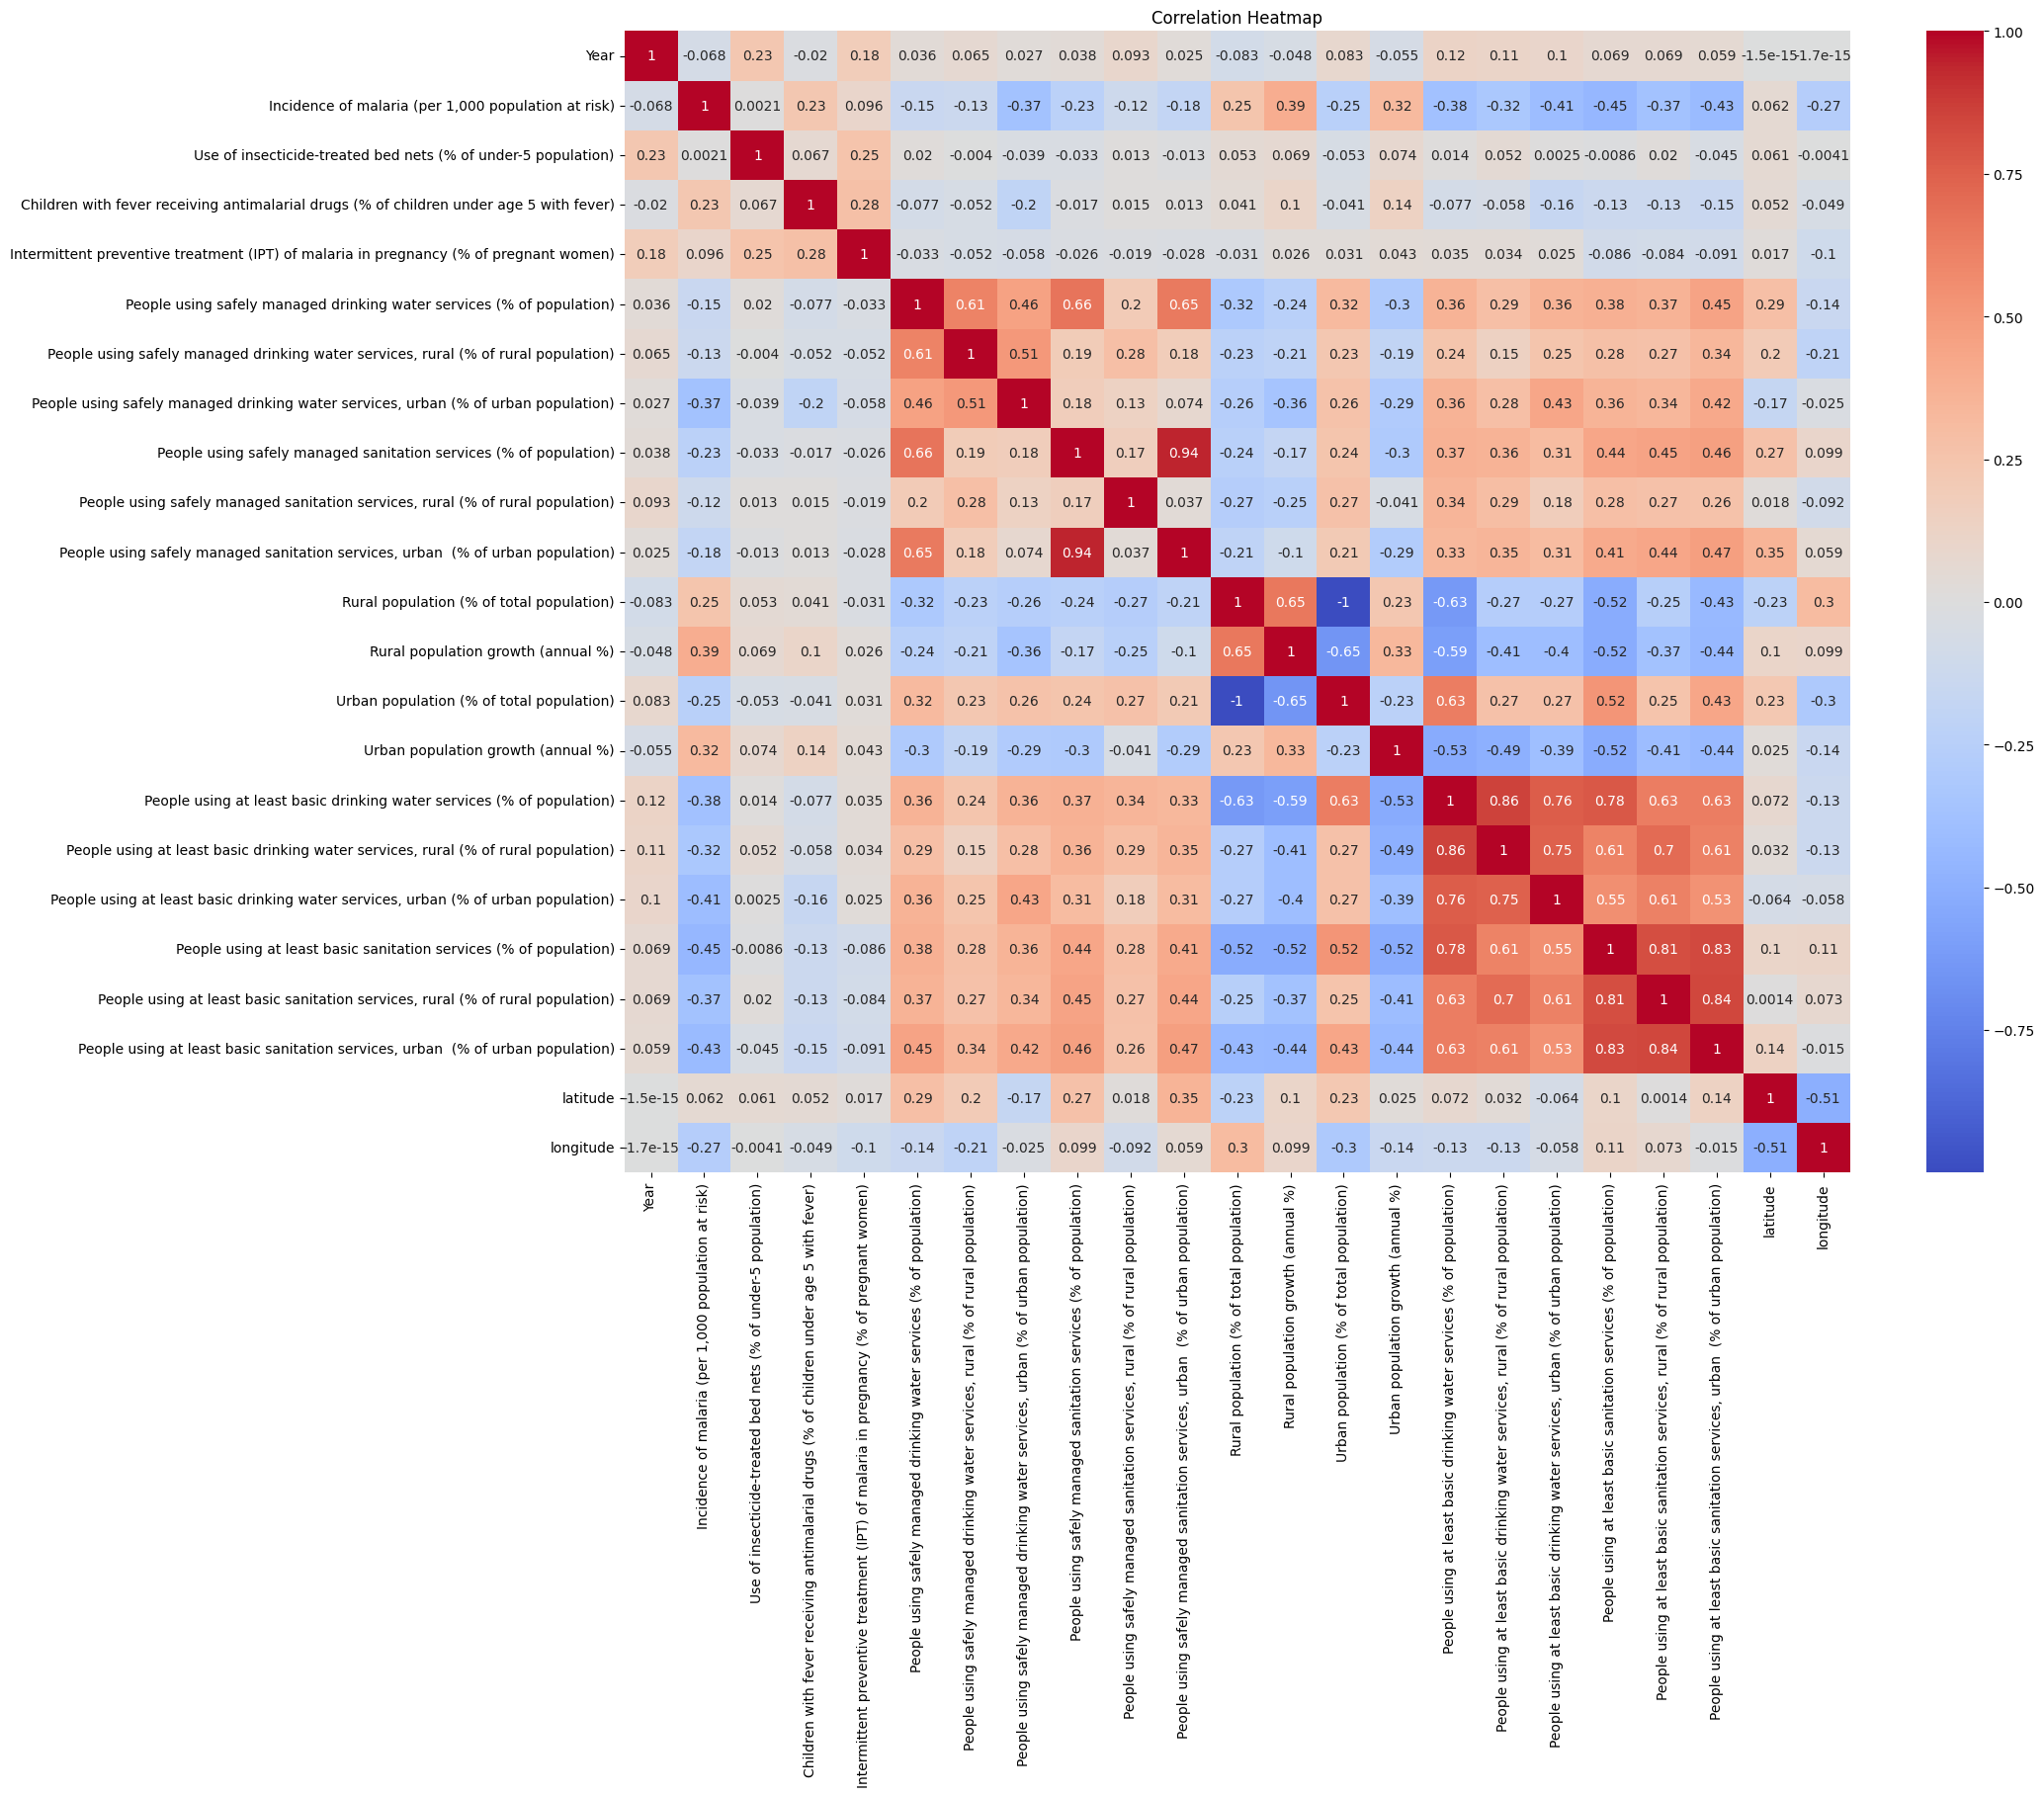

In [25]:
plt.figure(figsize=(20, 15))
corr = df_clean.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

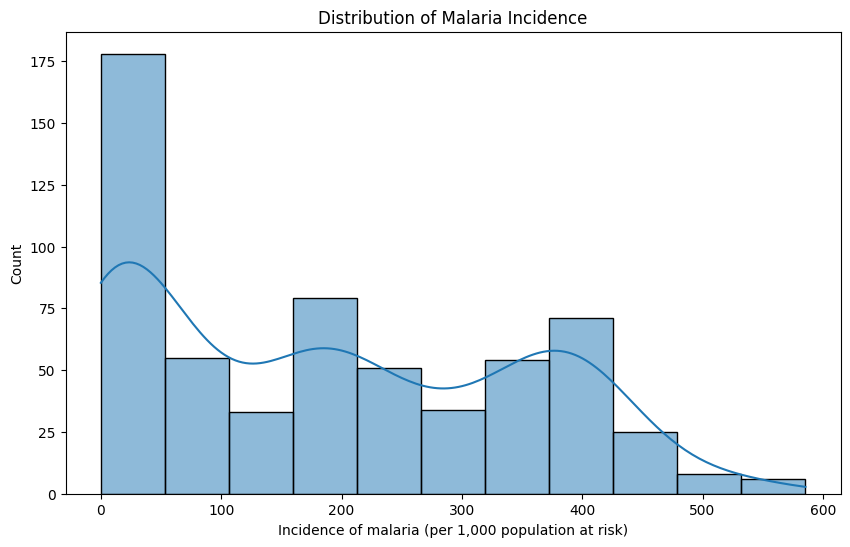

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Incidence of malaria (per 1,000 population at risk)'], kde=True)
plt.title('Distribution of Malaria Incidence')
plt.show()

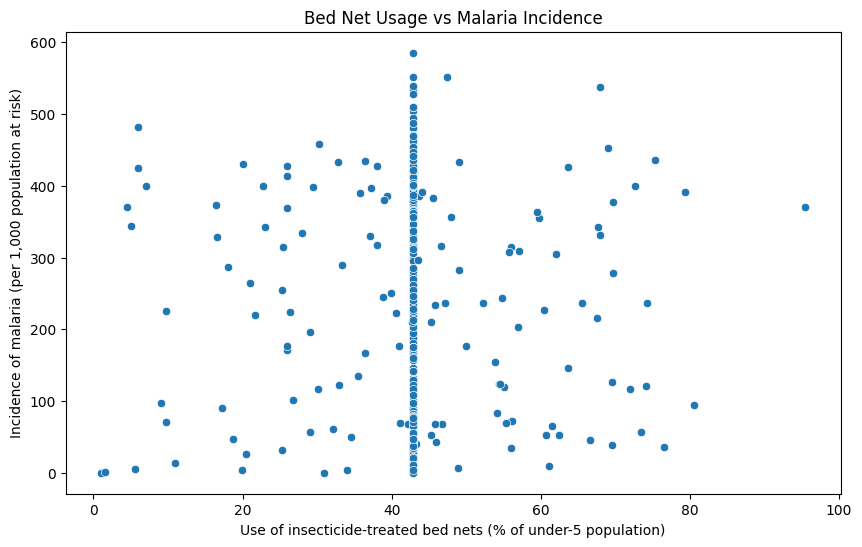

In [27]:
# Relationship between bed net usage and malaria incidence
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Use of insecticide-treated bed nets (% of under-5 population)',
                y='Incidence of malaria (per 1,000 population at risk)',
                data=df_clean)
plt.title('Bed Net Usage vs Malaria Incidence')
plt.show()

In [28]:
# Selection of features with highest correlation to target
target = 'Incidence of malaria (per 1,000 population at risk)'
correlation_threshold = 0.3
high_corr_features = corr[abs(corr[target]) > correlation_threshold].index.tolist()
high_corr_features.remove(target)

# Created the final dataset
final_df = df_clean[high_corr_features + [target]]

In [29]:
scaler = StandardScaler()
X = final_df.drop(target, axis=1)
y = final_df[target]

X_scaled = scaler.fit_transform(X)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [31]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
sgd.fit(X_train, y_train)

# Predictions
y_pred_sgd = sgd.predict(X_test)

# Evaluation
mse_sgd = mean_squared_error(y_test, y_pred_sgd)
r2_sgd = r2_score(y_test, y_pred_sgd)
print(f"SGDRegressor - MSE: {mse_sgd}, R2: {r2_sgd}")

SGDRegressor - MSE: 17264.983490743816, R2: 0.21824504846477777


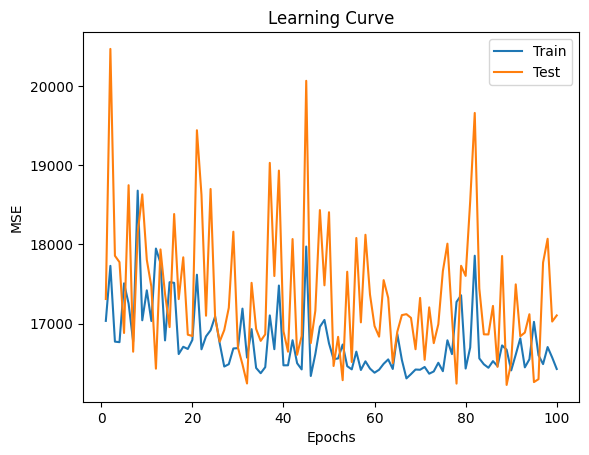

In [32]:
# Implementation of Custom Training
def plot_loss_curve(model, X_train, y_train, X_test, y_test, n_epochs=100):
    train_errors, test_errors = [], []

    for epoch in range(n_epochs):
        model.partial_fit(X_train, y_train)
        train_errors.append(mean_squared_error(y_train, model.predict(X_train)))
        test_errors.append(mean_squared_error(y_test, model.predict(X_test)))

    plt.plot(range(1, n_epochs+1), train_errors, label='Train')
    plt.plot(range(1, n_epochs+1), test_errors, label='Test')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

# Reinitialized the model
sgd = SGDRegressor(max_iter=1, tol=None, penalty=None, eta0=0.1, warm_start=True)
plot_loss_curve(sgd, X_train, y_train, X_test, y_test)

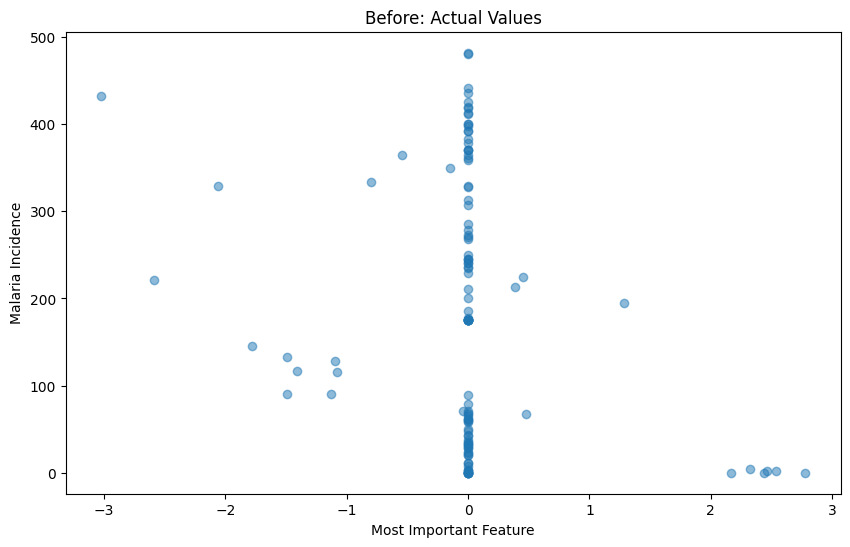

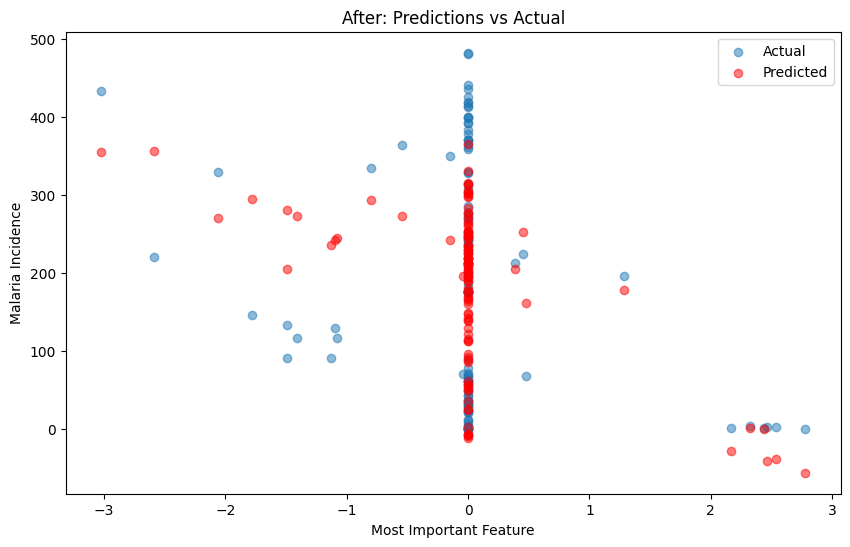

In [33]:
# Before Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], y_test, alpha=0.5)
plt.title('Before: Actual Values')
plt.xlabel('Most Important Feature')
plt.ylabel('Malaria Incidence')
plt.show()

# After Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], y_test, alpha=0.5, label='Actual')
plt.scatter(X_test[:, 0], y_pred_sgd, alpha=0.5, color='red', label='Predicted')
plt.title('After: Predictions vs Actual')
plt.xlabel('Most Important Feature')
plt.ylabel('Malaria Incidence')
plt.legend()
plt.show()

In [34]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

# Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Compared the results
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest'],
    'MSE': [mse_lr, mse_dt, mse_rf],
    'R2 Score': [r2_lr, r2_dt, r2_rf]
})

print(results)

               Model           MSE  R2 Score
0  Linear Regression  16936.194202  0.233133
1      Decision Tree   5919.669979  0.731959
2      Random Forest   3426.223583  0.844861


In [35]:
import joblib

#Random Forest performed best
joblib.dump(rf, 'malaria_incidence_predictor.pkl')

# Saved the Scaler
joblib.dump(scaler, 'scaler.pkl')

# Saved the feature names
import json
with open('feature_names.json', 'w') as f:
    json.dump(high_corr_features, f)

In [36]:
def predict_malaria_incidence(features):
    """
    features: Dictionary containing values for all required features
    Returns predicted malaria incidence rate
    """
    # Loaded the model and scaler
    model = joblib.load('malaria_incidence_predictor.pkl')
    scaler = joblib.load('scaler.pkl')

    # Loaded the feature names
    with open('feature_names.json', 'r') as f:
        feature_names = json.load(f)

    # Created input array in correct order
    input_data = [features[col] for col in feature_names]
    input_array = np.array(input_data).reshape(1, -1)

    # Scaled the input
    scaled_input = scaler.transform(input_array)

    # Made the prediction
    prediction = model.predict(scaled_input)

    return prediction[0]